In [22]:
#####################################
# Developed by Baptiste PICARD      #
# picard.baptiste@laposte.net       #
# Started the 21th of February 2020 #
#                                   #
#####################################

# imports
# utils 
import pandas as pd
import numpy as np
import time 
import seaborn as sns
from collections import Counter #outlier detect
import matplotlib.pyplot as plt
from scipy import stats 
from scipy.stats import norm, boxcox
import random
import json
import os
import subprocess
import datetime as dt

# Modules for keras regression.
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.callbacks import History
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 

# Modules for regression (https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb

# Environment 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

# Constants 
train_set = './data/train.csv'
test_set = './data/test.csv'
submission_set = './data/sample_submission.csv'

In [2]:
df_train = pd.read_csv(train_set) # Read .csv file
df_test = pd.read_csv(test_set) # Read .csv file
df_submission = pd.read_csv(submission_set) # Read .csv file

# Defining the sets.
df = df_train.drop(['Id'], axis=1) # X_train 
df_test = df_test.drop(['Id'], axis=1) # X_test 
# Defining the shape.
rows = df.shape[0]
columns = df.shape[1]
# Defining numeric and object feature indexes.
numeric_features_train = df.dtypes[df.dtypes != "object"]
object_features_train = df.dtypes[df.dtypes == "object"]
numeric_features_test = df_test.dtypes[df_test.dtypes != "object"]
object_features_test = df_test.dtypes[df_test.dtypes == "object"]
# Defining numeric and object feature count.
count_numeric_features_train = numeric_features_train.value_counts().sum() - 1 # Less SalePrice
count_object_features_train = object_features_train.value_counts().sum()
count_numeric_features_test = numeric_features_test.value_counts().sum()
count_object_features_test = object_features_test.value_counts().sum()
print("The dataset for house price prediction is composed by {} rows and {} columns.".format(rows, columns))
print("In the train set, there are {} numeric features and {} object features.".format(count_numeric_features_train, count_object_features_train))
print("In the test set, there are {} numeric features and {} object features.".format(count_numeric_features_test, count_object_features_test))

The dataset for house price prediction is composed by 1460 rows and 80 columns.
In the train set, there are 36 numeric features and 43 object features.
In the test set, there are 36 numeric features and 43 object features.


In [3]:
# Detecting some outliers -> Drop.
df.drop(df[np.logical_and(df['OverallQual'] < 5, df['SalePrice'] > 200000)].index, inplace=True)
df.drop(df[np.logical_and(df['GrLivArea'] > 4000, df['SalePrice'] < 300000)].index, inplace=True)
# Start shaping 
y_train = df["SalePrice"] # y_train
df = df.drop(['SalePrice'], axis=1)

<AxesSubplot:>

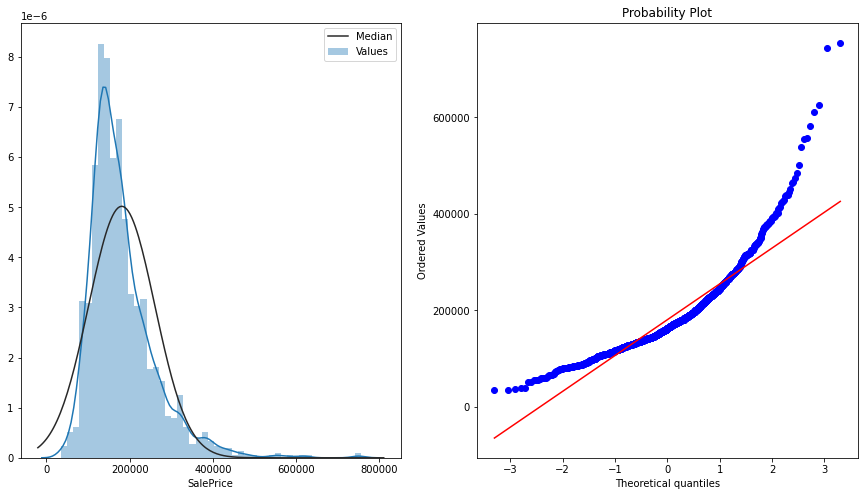

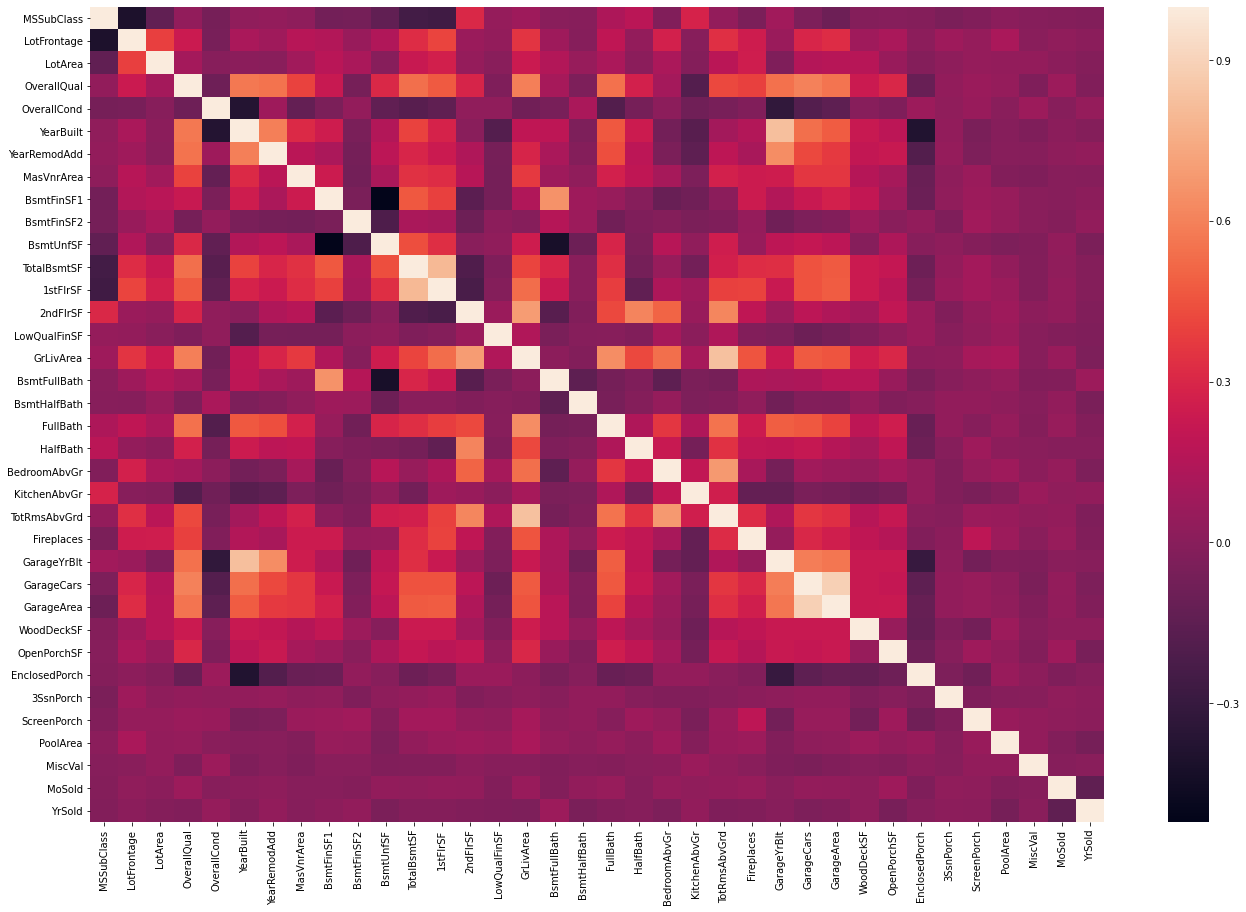

In [4]:
plt.figure(figsize=(15,8))
plt.title("Visualization of the SalePrices")
plt.subplot(121)
sns.distplot(y_train, fit=norm)
plt.legend(["Median", "Values"])
plt.subplot(122)
stats.probplot(y_train, plot=plt) # the normal distribution of the samples

plt.figure(figsize=(50,15))
plt.title("Visualization of the Correlation")
corr = df.corr()
plt.subplot(121)
sns.heatmap(corr)

((array([-3.30456314, -3.04731426, -2.90425334, ...,  2.90425334,
          3.04731426,  3.30456314]),
  array([10.46027076, 10.47197813, 10.54273278, ..., 13.34550853,
         13.52114084, 13.53447435])),
 (0.39849613072873646, 12.023720768946777, 0.9953596516661676))

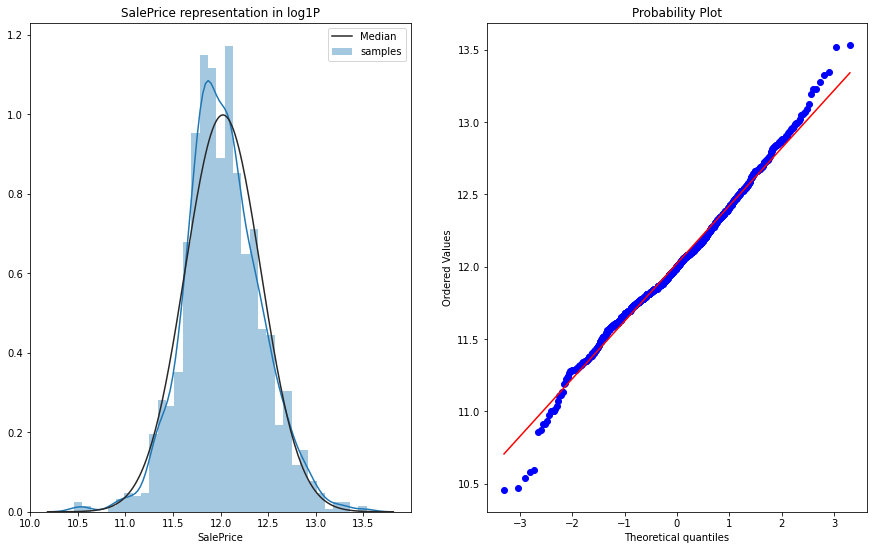

In [5]:
# transform the ouput price into logarithmic.
y_train = np.log1p(y_train)

plt.figure(figsize=(15,9))
plt.subplot(121)
sns.distplot(y_train, fit=norm)
plt.legend(["Median", "samples"])
plt.title("SalePrice representation in log1P")
plt.subplot(122)
stats.probplot(y_train, plot=plt) # the normal distribution of the samples

In [6]:
# https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm
# Skewness is a measure of symmetry, or more precisely, the lack of symmetry.
# A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

# Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. 
# That is, data sets with high kurtosis tend to have heavy tails, or outliers. 
# Data sets with low kurtosis tend to have light tails, or lack of outliers. 
# A uniform distribution would be the extreme case.
def transformData(df, df_test, labels_to_add=None) :
    le = preprocessing.LabelEncoder()
    shape = df
    if(labels_to_add != None) :
        shape = shape.append(pd.Series(labels_to_add), ignore_index=True)
    le.fit(shape)
    return le.transform(df), le.transform(df_test)

def sigmoid(df) : 
    e = np.exp(1)
    return 1/(1+e**(-df))

all_missing_values_train = df.isnull().sum().sum()
all_missing_values_test = df_test.isnull().sum().sum()
all_columns = df.columns

discrete_value_columns = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'MasVnrType', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 
     'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 
     'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 
     'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 
     'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
     'PavedDrive','PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MoSold', 'YrSold']

columns_nan_nones = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                     'Fireplaces', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 
                     'MiscFeature' ]

non_discrete_value_columns = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 
     'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'MasVnrArea', 
     'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
     'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
     'ScreenPorch', 'PoolArea', 'MiscVal']


for column in all_columns :
    if(df.isnull().sum()[column] != 0) : 
        if(column in discrete_value_columns) :
            if(column in columns_nan_nones) :
                df[column] = df[column].fillna("None")
            else :
                df[column] = df[column].fillna(df[column].mode()[0])
        elif(column in non_discrete_value_columns) :
            df[column] = df[column].fillna(np.mean(df[column]))
            
    if(df_test.isnull().sum()[column] != 0) :
        if(column in discrete_value_columns) :
            if(column in columns_nan_nones) :
                df_test[column] = df_test[column].fillna("None")
            else :
                df_test[column] = df_test[column].fillna(df_test[column].mode()[0])
        elif(column in non_discrete_value_columns) :
            df_test[column] = df_test[column].fillna(np.mean(df_test[column]))
    
    if(df.isnull().sum()[column]!=0 or df_test.isnull().sum()[column] !=0) :
        print('The column {} is not totally filled.'.format(column))
    else :
        if(column in discrete_value_columns) :
            labels_to_add = None
            if(column=='MSSubClass') :
                labels_to_add = [150]
            df[column], df_test[column] = transformData(df[column], df_test[column], labels_to_add)
        elif(column in non_discrete_value_columns) :
            # Apply normal transformed
            # df[column] = sigmoid(df[column])
            # df_test[column] = sigmoid(df_test[column])
            df[column] = pd.qcut(df[column].rank(method='first'), q=6, labels=[0, 1, 2, 3, 4, 5])
            df_test[column] = pd.qcut(df_test[column].rank(method='first'), q=6, labels=[0, 1, 2, 3, 4, 5])

# non_discrete_value_columns.append('TotalSF')

all_missing_values_train_actual = df.isnull().sum().sum()
all_missing_values_test_actual = df_test.isnull().sum().sum()
print("We passed from {} to {} missing values in the train set.".format(all_missing_values_train, all_missing_values_train_actual))
print("We passed from {} to {} missing values in the test set.".format(all_missing_values_test, all_missing_values_test_actual))

We passed from 6953 to 0 missing values in the train set.
We passed from 7000 to 0 missing values in the test set.


In [7]:
# Building my train set
X_train_f = df.values
y_train_f = y_train.values
print("Initial shape of X_train_f ({}) is {} ".format(type(X_train_f), X_train_f.shape))
print("Initial shape of y_train_f ({}) is {} ".format(type(y_train_f), y_train_f.shape))
input_shape = (columns, )
X_train_f, X_test, y_train_f, y_test = train_test_split(X_train_f, y_train_f, test_size=0.2, random_state=42)
print("Final shape of X_train_f ({}) is {} ".format(type(X_train_f), X_train_f.shape))
print("Final shape of y_train_f ({}) is {} ".format(type(y_train_f), y_train_f.shape))

Initial shape of X_train_f (<class 'numpy.ndarray'>) is (1457, 79) 
Initial shape of y_train_f (<class 'numpy.ndarray'>) is (1457,) 
Final shape of X_train_f (<class 'numpy.ndarray'>) is (1165, 79) 
Final shape of y_train_f (<class 'numpy.ndarray'>) is (1165,) 


In [8]:
X_eval = df_test.values
print("Shape of X_eval ({}) is {} ".format(type(X_eval), X_eval.shape))

Shape of X_eval (<class 'numpy.ndarray'>) is (1459, 79) 


In [9]:
random_forest = RandomForestRegressor(n_estimators=600, max_depth=55)
random_forest.fit(X_train_f, y_train_f)
Y_pred = random_forest.predict(X_eval)
acc_random_forest = round(random_forest.score(X_train_f, y_train_f) * 100, 2)
print("Accuracy of the Random Forest classifier = {}%".format(acc_random_forest))

Accuracy of the Random Forest classifier = 98.22%


In [10]:
for index in range(len(Y_pred)) : 
    df_submission.loc[df_submission.index[index], "SalePrice"] = np.expm1(Y_pred[index])
    
df_submission.to_csv(submission_set, index=False)

In [23]:
def generate_submission_file_based_on_prediction(result, source_file_path="data/sample_submission.csv"):
    df = pd.read_csv(
        filepath_or_buffer=source_file_path,
        sep=",",
    ).set_index("PassengerId")
    print(f"Entry: {df.shape}.")
    merge_df = pd.merge(
        left=df,
        right=result,
        how="left",
        left_index=True,
        right_index=True,
    )
    print(f"Output: {merge_df.shape}.")
    if df.shape[0] != merge_df.shape[0]:
        raise ValueError(f"Should be same size.")
    merge_df = merge_df[["Transported_x", "Transported_y"]]
    merge_df = merge_df.reset_index().rename(columns={"Transported_y": "Transported"}).drop(columns=["Transported_x"])
    merge_df.to_csv("data/my_submission.csv", sep=",", index=False)
    
def generate_random_submission(source_file_path="data/sample_submission.csv"):
    df = pd.read_csv(
        filepath_or_buffer=source_file_path,
        sep=",",
    )
    df["SalePrice"] = df["SalePrice"].apply(lambda x: random.uniform(100_000, 200_000))
    print(f"File data/my_submission.csv successfully generated.\n")
    df.to_csv("data/my_submission.csv", sep=",", index=False)
    
def submit_submission(submission_file="data/sample_submission.csv"):
    with open("kaggle.json") as credential:
        json_credential = json.loads(credential.read())
        os.environ["KAGGLE_USERNAME"] = json_credential["username"]
        os.environ["KAGGLE_KEY"] = json_credential["key"]
    result = subprocess.check_output(
        [
            "kaggle",
            "competitions",
            "submit",
            "house-prices-advanced-regression-techniques",
            "-f",
            submission_file,
            "-m",
            f"{dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}: New submission",
        ]
    ).decode("utf-8")
    print(result)

def get_latest_score(team_id="10059555"):
    with open("kaggle.json") as credential:
        json_credential = json.loads(credential.read())
        os.environ["KAGGLE_USERNAME"] = json_credential["username"]
        os.environ["KAGGLE_KEY"] = json_credential["key"]
        os.environ["KAGGLE_TEAM_ID"] = team_id
    result = subprocess.check_output(["kaggle", "competitions", "submissions", "house-prices-advanced-regression-techniques"]).decode("utf-8")
    print(result)

generate_random_submission()
submit_submission()
get_latest_score()

File data/my_submission.csv successfully generated.

Successfully submitted to House Prices - Advanced Regression Techniques
fileName               date                 description                          status    publicScore  privateScore  
---------------------  -------------------  -----------------------------------  --------  -----------  ------------  
sample_submission.csv  2023-08-23 20:57:44  2023-08-23 21:57:36: New submission  complete  0.14851                    
sample_submission.csv  2020-03-01 16:52:25                                       complete  0.14738                    
sample_submission.csv  2020-03-01 16:51:46                                       complete  0.23295                    
sample_submission.csv  2020-03-01 16:51:00                                       complete  0.16785                    
sample_submission.csv  2020-03-01 16:25:24                                       complete  0.14815                    
sample_submission.csv  2020-03-01 16:24:02